In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Background

### Initial datasets

We obtained 15 features

## Exploratory data analysis
**EDA is very useful for gaining initial insights on the datasets**
1. Defining Important Functions:
- Plotting
2. Data Pre-Processing
- Trimming + Renaming cols
- Generation of Categorical cols
3. Plotting
- Univariate 
- Bivariate


In [11]:
PLOTS_TO_FUNC = {
    "Hist": sns.histplot,
    "KDE": sns.kdeplot,
    "Ecdf": sns.ecdfplot,
    "Bar": sns.barplot,
    "Scatter": sns.scatterplot,
    "Violin": sns.violinplot,
    "Line": sns.lineplot
}

def rotate_axis(
    fig,
) -> bool:
    """
    Dynamic rotation of x axis labels
    """
    num_labels = len(fig.get_xticklabels())
    if num_labels >= 5:
        return True
    else:
        return False

def save_fig(
    fig,
    dest_path,
    file_name
):
    locs, labels = plt.xticks()
    if rotate_axis(fig):
        plt.setp(labels,rotation=45, horizontalalignment="right")
    else:
        plt.setp(labels, horizontalalignment="right")

    plt.savefig(os.path.join(dest_path, file_name), dpi=300, bbox_inches="tight")
    plt.close()

### Data cleaning

In [3]:
# Read the CSV file
df = pd.read_csv("..\..\datasets\Processed\All_DF_Processed.csv")
df.head()

,ISO3_Code,Country_Name,M49_Code,Life_Expectancy_2016,Life_Expectancy_2017,Life_Expectancy_2018,Life_Expectancy_2019,Life_Expectancy_2020,Mean_Years_Of_Schooling_2016,Mean_Years_Of_Schooling_2017,...,Corruption_Perception_Index_2020,Corruption_Perception_Index_2019,Corruption_Perception_Index_2018,Corruption_Perception_Index_2017,Corruption_Perception_Index_2016,Prevalence_of_undernourishment_2016,Prevalence_of_undernourishment_2017,Prevalence_of_undernourishment_2018,Prevalence_of_undernourishment_2019,Prevalence_of_undernourishment_2020
0,AFG,Afghanistan,4.0,63.1361,63.0160,63.0810,63.5645,62.5751,2.463660,2.561425,...,19.0,16.0,16.0,15.0,15.0,22.2,23.0,24.0,26.9,29.8
1,AGO,Angola,24.0,61.0923,61.6798,62.1438,62.4484,62.2612,5.417391,5.417391,...,27.0,26.0,19.0,19.0,18.0,15.4,15.4,15.7,17.9,20.8
2,ALB,Albania,8.0,78.8602,79.0473,79.1838,79.2825,76.9893,10.727528,10.910692,...,36.0,35.0,36.0,38.0,39.0,4.7,4.7,4.6,4.3,3.9
3,ARE,United Arab Emirates,784.0,79.3347,79.5036,79.6274,79.7262,78.9457,10.842620,12.055400,...,71.0,71.0,70.0,71.0,66.0,6.3,6.4,6.2,6.0,5.6
4,ARG,Argentina,32.0,76.3077,76.8330,76.9994,77.2845,75.8921,10.928190,11.016445,...,42.0,45.0,40.0,39.0,36.0,2.6,3.1,3.4,3.5,3.7


### Plots

1. Heatmap
2. Pairplot
3. Distribution plots (transform data to categorical for further analysis)

## Preliminary model

In [8]:
def remove_outliers(df_in, df_out):
    mean, std = df_in.mean(), df_in.std()
    lower, upper = mean - 3 * std, mean + 3 * std  # type pd.Series
    out1 = df_in.index[(df_in < lower).any(axis=1)]
    out2 = df_in.index[(df_in > upper).any(axis=1)]
    # print(out1.union(out2))
    idxs = df_in.index.drop(out1.union(out2))
    df_in = df_in.loc[idxs].copy().reset_index(drop=True)
    df_out = df_out.loc[idxs].copy().reset_index(drop=True)
    return df_in, df_out

def normalize_z(dfin):
    df_new = (dfin - dfin.mean(axis=0)) / dfin.std(axis=0)
    return df_new

def get_features_targets(df, feature_names, target_names):
    df_feature = df[feature_names].copy()
    df_target = df[target_names].copy()
    return df_feature, df_target

def prepare_feature(df_feature):
    m = df_feature.shape[0]
    Xtmp = df_feature.to_numpy().reshape(m, len(df_feature.columns))
    X = np.concatenate((np.ones((m,1)), Xtmp), axis=1) # m * (n+1)
    return X

def prepare_target(df_target):
    m = df_target.shape[0]
    return df_target.to_numpy().reshape(m, 1)

def predict(df_feature, beta):
    df_feature_norm = normalize_z(df_feature)
    features = prepare_feature(df_feature_norm)
    yhat = calc_linear(features, beta)
    return yhat

def calc_linear(X, beta):
    return np.matmul(X, beta)

def split_data(df_feature, df_target, random_state=None, test_size=0.5):
    total = df_feature.shape[0]
    n = int(test_size * total)
    
    np.random.seed(random_state)
    n_idxs = np.random.choice(total, n, replace=False)
    m_idxs = np.array([i for i in range(total) if i not in n_idxs])
    
    df_feature_train, df_target_train = df_feature.loc[m_idxs].copy(), df_target.loc[m_idxs].copy()
    df_feature_test, df_target_test = df_feature.loc[n_idxs].copy(), df_target.loc[n_idxs].copy()
    
    return df_feature_train, df_feature_test, df_target_train, df_target_test


### Preprocessing
0. (null values already replaced with mean in loaded dataset)
1. Remove outliers (< or > 3*std)
2. Normalize features

In [16]:
# Extract the features and the targets
tmp = df.columns[df.columns.str.contains("_2020")].tolist()
feature_names, output_names = tmp[:-1], tmp[-1:]
df_features, df_target = get_features_targets(df, feature_names, output_names)
n = len(df_features.columns)

print(df_features.columns)
print(df_features.shape, df_target.shape)


Index(['Life_Expectancy_2020', 'Mean_Years_Of_Schooling_2020', 'CPI_Food_2020',
       'Net_FDI_2020', 'Infant_Mortality_Rate_2020', 'Unemployment_2020',
       'Access_To_Electricity_2020', 'Fertility_Rate_2020',
       'Immunization_Measles_2020', 'Labor_Force_Gender_Ratio_2020',
       'Corruption_Perception_Index_2020'],
      dtype='object')
(148, 11) (148, 1)


In [17]:
# Remove outliers
df_features, df_target = remove_outliers(df_features, df_target)
print("No. of outliers dropped:", df.shape[0] - df_features.shape[0])

No. of outliers dropped: 53


97.275227

### Model training

In [15]:
def compute_cost(X, y, beta):
    m = X.shape[0]
    yhat = calc_linear(X, beta)
    J = (1 / 2 / m) * np.matmul((yhat - y).T, (yhat - y))
    return J

def gradient_descent(X, y, beta, alpha, num_iters):
    m = X.shape[0]
    J_storage = []
    for i in range(num_iters):
        yhat = calc_linear(X, beta)
        first = X.T * alpha / m
        second = yhat - y
        beta = beta - np.matmul(first, second)
        cost = compute_cost(X, y, beta)
        J_storage.append(cost)
    return beta, J_storage

In [19]:
# Split the data set into training and test
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, 100, 0.3)

# Normalize the features using z normalization
df_features_train_z = normalize_z(df_features_train)

# Change the features and the target to numpy array using the prepare functions
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((n+1,1))

# Call the gradient_descent function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

# call the predict() method
pred = predict(df_features_test, beta)

### Model evaluation

In [17]:
def r2_score(target, pred):
    SSres = np.sum((target - pred) ** 2)
    SStot = np.sum((target - np.mean(target)) ** 2)
    return 1 - SSres / SStot

def mean_squared_error(target, pred):
    return np.mean((target - pred) ** 2)

def mean_absolute_error(target, pred):
    return np.mean(np.abs(target - pred))

def adjusted_r2_score(target, pred, num_features):
    r2, n, p = r2_score(target, pred), target.shape[0], num_features
    return 1 - (1 - r2) * (n-1) / (n-p-1)

def mean_absolute_percentage_error(y, pred):
    return np.mean(np.abs(target - pred) / target)

In [21]:
# Evaluate the model 
target = prepare_target(df_target_test)

r2 = r2_score(target, pred)
adj_r2 = adjusted_r2_score(target, pred, n)
mse = mean_squared_error(target, pred)
mae = mean_absolute_error(target, pred)
mape = mean_absolute_percentage_error(target, pred)

print(r2)
print(adj_r2)
print(mse)
print(mae)
print(mape)


0.41061951578318223
0.17050154073188606
85.68979222809682
6.261088014014715
0.9421413373298412


=> Selected metrics for fine tuning: Adjusted R2 Score & MAE

## Fine tuning

### Feature selection
0. Generate different combinations of features
1. Test which combination performs the best
2. Visualize correlation between different features
3. Calculate Variance Inflation Factor (VIF) for each feature
4. Select optimal combination

In [22]:
# Extract the features and the targets
tmp = df.columns[df.columns.str.contains("_2020")].tolist()
feature_names, output_names = tmp[:-1], tmp[-1:]

# Generate different combinations of features
from itertools import combinations
combis, r2s, maes, betas = [], {}, {}, {}
for i in range(3, len(feature_names)+1):
    combis += [list(x) for x in list(combinations(feature_names, i))]

for combi in combis:
    df_features, df_target = get_features_targets(df, combi, output_names)
    n = len(df_features.columns)
    df_features, df_target = remove_outliers(df_features, df_target)

    # Split the data set into training and test
    df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, 100, 0.3)

    # Normalize the features using z normalization
    df_features_train_z = normalize_z(df_features_train)

    # Change the features and the target to numpy array using the prepare functions
    X = prepare_feature(df_features_train_z)
    target = prepare_target(df_target_train)

    iterations = 1500
    alpha = 0.01
    beta = np.zeros((n+1,1))

    # Call the gradient_descent function
    beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

    # Call the predict() method
    pred = predict(df_features_test, beta)

    # Evaluate the model
    target = prepare_target(df_target_test)
    r2s[str(combi)] = adjusted_r2_score(target, pred, n)
    maes[str(combi)] = mean_absolute_error(target, pred)
    betas[str(combi)] = beta

# Sort all r2 scores from high to low
r2s = {k: v for k, v in sorted(r2s.items(), key=lambda item: item[1], reverse=True)}
for item in list(r2s.items())[:5]:
    print("\nFeatures:", item[0])
    print("Adjusted r2_score:", item[1])
    print("MAE:", maes[item[0]])



Features: ['Net_FDI_2020', 'Access_To_Electricity_2020', 'Corruption_Perception_Index_2020']
Adjusted r2_score: 0.7026593368259044
MAE: 3.751501580481668

Features: ['Net_FDI_2020', 'Access_To_Electricity_2020', 'Fertility_Rate_2020', 'Corruption_Perception_Index_2020']
Adjusted r2_score: 0.7012995098613872
MAE: 3.705827227637069

Features: ['Mean_Years_Of_Schooling_2020', 'Net_FDI_2020', 'Access_To_Electricity_2020', 'Corruption_Perception_Index_2020']
Adjusted r2_score: 0.6926202905466978
MAE: 3.779504068319886

Features: ['Life_Expectancy_2020', 'Net_FDI_2020', 'Access_To_Electricity_2020', 'Corruption_Perception_Index_2020']
Adjusted r2_score: 0.6919208351917403
MAE: 3.7671431958316117

Features: ['Mean_Years_Of_Schooling_2020', 'Net_FDI_2020', 'Access_To_Electricity_2020', 'Fertility_Rate_2020', 'Corruption_Perception_Index_2020']
Adjusted r2_score: 0.6883877651592659
MAE: 3.7551421241777385


In [23]:
# Correlation graphs TODO

In [24]:
# Write function for VIF
# Detect how correlated 1 feature is against the others
# 1 (not correlated), 1 - 5 (moderately correlated), > 5 (highly correlated)
def vif(response, explanatory):
    # Get features and targets
    df_features, df_target = get_features_targets(df, explanatory, response)
    n = len(df_features.columns)
    df_features, df_target = remove_outliers(df_features, df_target)

    # Normalize the features using z normalization
    df_features_z = normalize_z(df_features)

    # Change the features and the target to numpy array using the prepare functions
    X = prepare_feature(df_features_z)
    target = prepare_target(df_target)

    iterations = 1500
    alpha = 0.01
    beta = np.zeros((n+1,1))

    # Call the gradient_descent function
    beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

    # Call the predict() method for all data
    pred = predict(df_features, beta)

    # Evaluate the model
    r2 = r2_score(target, pred)
    vif = 1 / (1 - r2)
    return vif


In [25]:
import json, itertools

# Get all features included in top 5 combis
tmp1 = []
tmp = [item[0] for item in list(r2s.items())[:5]]
for x in tmp:
    tmp1 += x[1:-1].replace(' ', '').replace('\'', '').replace('\"', '').split(',') 
feature_names_top_5 = np.unique(np.array(tmp1).flatten()).tolist()

# Calculate VIF 
vifs = {}
for i, feature in enumerate(feature_names_top_5):
    vifs[feature] = vif([feature], feature_names_top_5[:i]+feature_names_top_5[i+1:])

# Sort all VIF scores from low to high
vifs = {k: v for k, v in sorted(vifs.items(), key=lambda item: item[1], reverse=False)}
vifs

{'Net_FDI_2020': 1.025015140534003,
 'Corruption_Perception_Index_2020': 2.451619003606814,
 'Mean_Years_Of_Schooling_2020': 2.929805224342769,
 'Access_To_Electricity_2020': 3.7691377491230154,
 'Fertility_Rate_2020': 4.436478466369317,
 'Life_Expectancy_2020': 5.501195798518766}

=> Selected combi of features: 
1. Net_FDI_2020
2. Access_To_Electricity_2020
3. Fertility_Rate_2020
4. Corruption_Perception_Index_2020

In [11]:
selected_combi = ['Net_FDI_2020', 'Access_To_Electricity_2020', 'Fertility_Rate_2020', 'Corruption_Perception_Index_2020']
output_names = ['Prevalence_of_undernourishment_2020']

df_features, df_target = get_features_targets(df, selected_combi, output_names)
n = len(df_features.columns)
df_features, df_target = remove_outliers(df_features, df_target)

# Split the data set into training and test
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, 100, 0.3)

target = prepare_target(df_target_test)
pred = predict(df_features_test, betas[str(selected_combi)])

sns.regplot(x=target,y=pred,ci=None,color='blue')

NameError: name 'betas' is not defined

### Log transformation

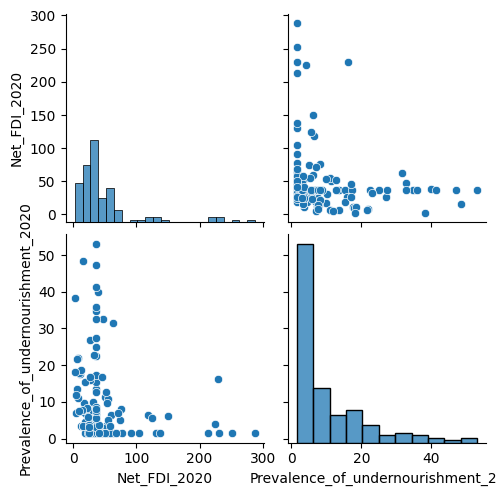

In [93]:
selected_combi = ['Net_FDI_2020', 'Access_To_Electricity_2020', 'Fertility_Rate_2020', 'Corruption_Perception_Index_2020']
df_features = df[selected_combi].copy()
df_features[selected_combi[0]] = df_features[selected_combi[0]] ** (1/2)
#df_features[selected_combi[1]] = np.log(-df_features[selected_combi[1]]+df_features[selected_combi[1]].median())
df_features[selected_combi[2]] = 1 / (df_features[selected_combi[2]])
sns.pairplot(data=pd.concat([df_features[[selected_combi[0]]], df[output_names]], axis=1))

0    1.131503
1    1.011651
2    0.453659
3    0.574256
4    0.436111
5    0.417588
6    0.135155
7    0.135155
8    0.135155
9    0.135155
Name: Prevalence_of_undernourishment_2020, dtype: float64


<AxesSubplot: xlabel='Prevalence_of_undernourishment_2020', ylabel='Density'>

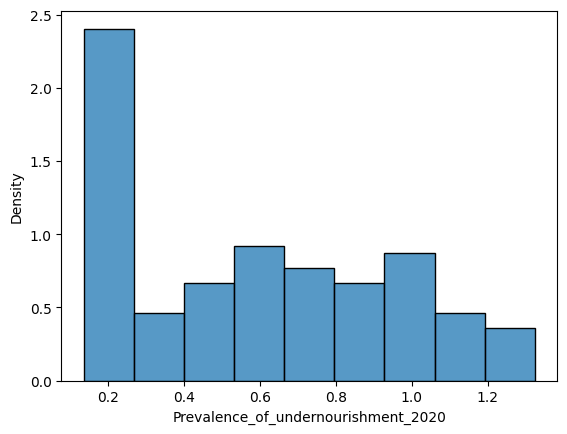

In [105]:
# plot histogram for distribution of dependent var after log transformation
df_target = df[output_names[0]].copy()
#df_target = (df_target - df_target.mean()) / (df_target.max() - df_target.min()) 
df_target = np.log((df_target) ** (1 / 3))
#df_target.fillna(df_target.mean(), inplace=True)
print(df_target[:10])
sns.histplot(df_target, stat="density")

(141, 4) (141, 1)
0.7052053500330748
3.709541130788714


<AxesSubplot: >

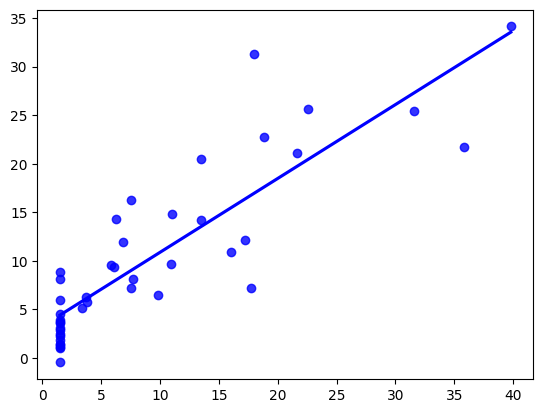

In [99]:
df_features, df_target = get_features_targets(df, selected_combi, output_names)
n = len(df_features.columns)
df_features, df_target = remove_outliers(df_features, df_target)

# Apply transformation to independent var
# Link to log transformations: https://kenbenoit.net/assets/courses/ME104/logmodels2.pdf
# df_target = (df_target - df_target.min()) / (df_target.max() - df_target.min()) * 2 - 1
# df_target = np.arctanh(df_target)
# print(df_target[:5])

# Apply transformation to dependent vars
#df_features[selected_combi[0]] = df_features[selected_combi[0]] ** (1/3)
#df_features[selected_combi[1]] = 1 / ((df_features[selected_combi[1]]).max()-df_features[selected_combi[1]])
df_features[selected_combi[2]] = 1 / (df_features[selected_combi[2]])
#df_features.fillna(df_features.mean(), inplace=True)
print(df_features.shape, df_target.shape)

# Split the data set into training and test
df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, 100, 0.3)

# Normalize the features using z normalization
df_features_train_z = normalize_z(df_features_train)

# Change the features and the target to numpy array using the prepare functions
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta = np.zeros((n+1,1))

# Call the gradient_descent function
beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

# call the predict() method
pred = predict(df_features_test, beta)

# Evaluate the model 
target = prepare_target(df_target_test)
adj_r2 = adjusted_r2_score(target, pred, n)
mae = mean_absolute_error(target, pred)
print(adj_r2)
print(mae)

sns.regplot(x=target,y=pred,ci=None,color='blue')

### Hyperparameter tuning

In [173]:
import json
combis_best_5 = [json.loads(json.dumps(item[0])) for item in list(r2s.items())[:5]]
lrs = [0.003, 0.01, 0.03, 0.1, 0.3]
r2s_lr, maes_lr = {}, {}

for combi in combis:
    if str(combi) not in r2s_lr:
        r2s_lr[str(combi)], maes_lr[str(combi)] = [], []

    df_features, df_target = get_features_targets(df, combi, output_names)
    n = len(df_features.columns)
    df_features, df_target = remove_outliers(df_features, df_target)

    # Split the data set into training and test
    df_features_train, df_features_test, df_target_train, df_target_test = split_data(df_features, df_target, 100, 0.3)

    # Normalize the features using z normalization
    df_features_train_z = normalize_z(df_features_train)

    # Change the features and the target to numpy array using the prepare functions
    X = prepare_feature(df_features_train_z)
    target = prepare_target(df_target_train)

    for lr in lrs:
        iterations = 1500
        alpha = lr
        beta = np.zeros((n+1,1))

        # Call the gradient_descent function
        beta, J_storage = gradient_descent(X, target, beta, alpha, iterations)

        # Call the predict() method
        pred = predict(df_features_test, beta)

        # Evaluate the model
        y_test = prepare_target(df_target_test)
        r2s_lr[str(combi)].append(adjusted_r2_score(y_test, pred, n))
        maes_lr[str(combi)].append(mean_absolute_error(y_test, pred))

for item in list(r2s_lr.items())[:5]:
    print("\nFeatures:", item[0])
    print("Adjusted r2_score:", item[1])
    print("MAE:", maes_lr[item[0]])

KeyboardInterrupt: 